Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 1)]          0         
_________________________________________________________________
input (Conv1D)               (None, 240, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 120, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 16)            1552      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 16)            0   

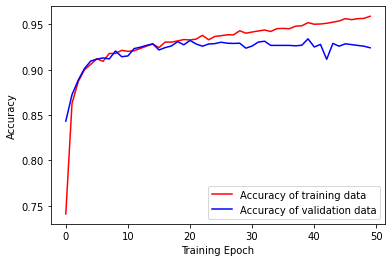

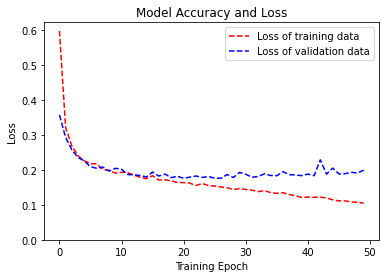

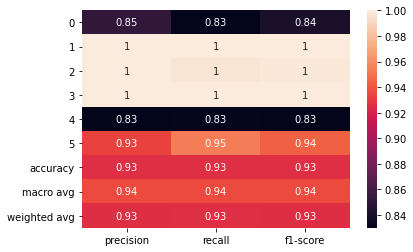

In [2]:

# -*- coding: utf-8 -*-
"""
Created on Thu May  7 13:08:51 2021

@author: Loubna Fares
"""
#Import Libraries

from __future__ import print_function
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
from IPython.display import display, HTML
import numpy
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input
import tensorflow as tf
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import precision_recall_curve, roc_curve
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils


def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
data= read_data('raw.txt')

df_1=data[data['activity']=='Jogging']
df_2=data[data['activity']=='Walking']
df_3=data[data['activity']=='Upstairs']
df_4=data[data['activity']=='Downstairs']
df_5=data[data['activity']=='Standing']
df_0=(data[data['activity']=='Sitting'])

#Upsampling : We upsample each class(0,1,2,3,4,5)
df_0_upsample=resample(df_0,replace=True,n_samples=444317,random_state=121)
df_1_upsample=resample(df_1,replace=True,n_samples=444317,random_state=125)
df_2_upsample=resample(df_2,replace=True,n_samples=444398,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=444398,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=444398,random_state=120)
df_5_upsample=resample(df_5,replace=True,n_samples=444398,random_state=129)

#concatinate the balanced data.
df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])



LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())
pd.options.mode.chained_assignment = None  # default='warn'
df['x-axis'] = df['x-axis'] / df['x-axis'].max()
df['y-axis'] = df['y-axis'] / df['y-axis'].max()
df['z-axis'] = df['z-axis'] / df['z-axis'].max()
# Round numbers
df= df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x, y= create_segments_and_labels(df, TIME_PERIODS,
                                    STEP_DISTANCE,
                                    LABEL)


# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Reshape 80*3 2D List into 240*1 1D list (Becasue we will use 1D CNN)
X_train= X_train.reshape(len(X_train), -1,1)
X_test = X_test.reshape(len(X_test), -1,1)

# Encoding of output labels into multicalss labels
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

#input shape of CCN model
input_data = keras.Input(shape=(X_train.shape[1], 1))

# Fucntion of classifier
def classifier_CNN(input_data):
    #encoder
    
    x = layers.Conv1D(64, kernel_size=3,activation='relu',padding='same', name='input')(input_data)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(8, kernel_size=3, activation='relu', padding='same')(x)
    x=layers.Flatten()(x)
    x=layers.Dense(118, activation='relu')(x)
    
    decoded=layers.Dense(6,  activation='softmax')(x)
    
    return decoded
#----------------------------------------------Model Compile---------------------------------------------------------------------
input_data = keras.Input(shape=(X_train.shape[1], 1))

#instintiate model
classifier = keras.Model(input_data, classifier_CNN(input_data))

#compile model
classifier.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#Print summary of classifier(model)
classifier.summary()

#Fit model (Training of model)
history = classifier.fit(X_train,y_train,shuffle=True, batch_size=200,epochs=50,verbose=1,
                                validation_split=0.1 ,callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

#Make predictions using trained classifier
y_train_pred = classifier.predict(X_test)

#Plot Accuracy and loss of Model training
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.legend()

plt.show()
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#Plot performance measures (Accuracy, F1-score, reacll, precision) of predicted data. 
target_names = list("012345")
max_y=np.argmax(y_test,axis=1)
max_y_pred_train=np.argmax(y_train_pred,axis=1)
clf_report = classification_report(max_y, max_y_pred_train, target_names=target_names,output_dict=True)
plt.show(sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True))   







